# Prediction of Sharpe ratio for blends of quantitative strategies

In [1120]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from xgboost import XGBRegressor 

from joblib import load

import tensorflow as tf
from keras import backend as K

## Data exploration

In [1121]:
data = pd.read_csv("Data/Training_Input_2dx8C9Q.csv")
y = pd.read_csv("Data/Training_Output_IJhBXtA.csv")
test = pd.read_csv("Data/Testing_Input_dPKY3Rf.csv")

In [56]:
data.shape

(10000, 218)

In [57]:
data.head()

,ID,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_20,I_1_lag_19,...,X_3_lag_9,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0
0,0,0.15,0.00,0.05,0.80,0.00,0.0,0.00,100.0,100.047398,...,101.383783,102.054669,102.375596,103.148605,103.148605,103.046483,103.075701,103.134043,103.221509,103.338192
1,1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,100.0,99.912339,...,100.911142,100.938707,100.993926,101.132016,100.745489,100.524617,100.303743,100.276090,100.303743,100.554527
2,2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,100.0,99.481681,...,100.373084,100.581716,100.313489,100.790251,101.013756,100.686030,100.686030,100.060233,99.747384,99.970889
3,3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,100.0,100.124618,...,100.844136,101.040072,101.055122,101.567682,101.703322,101.974603,101.733422,101.838963,102.080144,101.688272
4,4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,100.0,100.000000,...,99.665093,99.482389,99.604192,100.030499,99.847797,100.426310,100.426310,100.822217,100.913521,100.852619


In [196]:
y.shape

(10000, 2)

In [197]:
y.head()

,ID,Target
0,0,-12.007941
1,1,2.294867
2,2,0.652308
3,3,2.412364
4,4,8.517471


In [60]:
test.shape

(4450, 218)

In [1122]:
data = data.set_index("ID")
y = y.set_index("ID")
test = test.set_index("ID")

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 217 entries, weight_I_1 to X_3_lag_0
dtypes: float64(217)
memory usage: 16.6 MB


In [199]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  10000 non-null  float64
dtypes: float64(1)
memory usage: 156.2 KB


In [200]:
# Missing values ?
print(True in data.isna(), True in y.isna(), True in test.isna())

False False False


In [66]:
# Let's see the columns to understand the construction of the dataset. 
# It begins with lag_20 and finishes with lag_0 for the 10 time series. 
# So lag_20 represent the fist day of a month set to a value of "100" of investment.
list(data.columns)

['weight_I_1',
 'weight_I_2',
 'weight_I_3',
 'weight_I_4',
 'weight_I_5',
 'weight_I_6',
 'weight_I_7',
 'I_1_lag_20',
 'I_1_lag_19',
 'I_1_lag_18',
 'I_1_lag_17',
 'I_1_lag_16',
 'I_1_lag_15',
 'I_1_lag_14',
 'I_1_lag_13',
 'I_1_lag_12',
 'I_1_lag_11',
 'I_1_lag_10',
 'I_1_lag_9',
 'I_1_lag_8',
 'I_1_lag_7',
 'I_1_lag_6',
 'I_1_lag_5',
 'I_1_lag_4',
 'I_1_lag_3',
 'I_1_lag_2',
 'I_1_lag_1',
 'I_1_lag_0',
 'I_2_lag_20',
 'I_2_lag_19',
 'I_2_lag_18',
 'I_2_lag_17',
 'I_2_lag_16',
 'I_2_lag_15',
 'I_2_lag_14',
 'I_2_lag_13',
 'I_2_lag_12',
 'I_2_lag_11',
 'I_2_lag_10',
 'I_2_lag_9',
 'I_2_lag_8',
 'I_2_lag_7',
 'I_2_lag_6',
 'I_2_lag_5',
 'I_2_lag_4',
 'I_2_lag_3',
 'I_2_lag_2',
 'I_2_lag_1',
 'I_2_lag_0',
 'I_3_lag_20',
 'I_3_lag_19',
 'I_3_lag_18',
 'I_3_lag_17',
 'I_3_lag_16',
 'I_3_lag_15',
 'I_3_lag_14',
 'I_3_lag_13',
 'I_3_lag_12',
 'I_3_lag_11',
 'I_3_lag_10',
 'I_3_lag_9',
 'I_3_lag_8',
 'I_3_lag_7',
 'I_3_lag_6',
 'I_3_lag_5',
 'I_3_lag_4',
 'I_3_lag_3',
 'I_3_lag_2',
 'I_3_la

In [ ]:
# There is up to 50 different samples (different weights) for the same time serie of 26 days 
# (21 days of training and 5 days of prediction)
# given a train dataset of 10 000 samples, if there are exactly 50 differents, we should obtain :
# 10 000/50 = 200 unique (values) time series 

In [679]:
# I think any strategy I or macro feature X could allow to find the number of unique values,
# because for 20 different variations over the 21 days, only the same variations can give a same final value
# there is no place for hazard here. 

# For strategy I_1 (for example) we can find our same 200 time series starting at lag_7 (14th day of the month)
for i in range(0,21):
    print(i,data["I_2_lag_"+str(i)].nunique())

0 200
1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 193
20 1


In [50]:
# Let's check for the test dataset with I_7 (for example) 
for i in range(0,21):
    print(i,test["I_7_lag_"+str(i)].nunique())

0 89
1 89
2 89
3 89
4 89
5 89
6 89
7 88
8 87
9 87
10 86
11 86
12 84
13 84
14 83
15 82
16 80
17 80
18 79
19 77
20 1


In [51]:
# Same, i find the 89 unique values expected. 

In [164]:
# The metric is a L1 norm with values smoothed by a fonction : f(x) = sig(x)*exp(-1/abs(x))
# The models will be train with the smoothed values of y 

In [1123]:
y["smoothed"] = y.apply(lambda x: np.sign(x)*np.exp(-1/abs(x)))

## Creating the customized cross_val 

In [67]:
# A difficulty here is that the different samples for a same time serie are shuffled into the dataset. 
# So I can not just randomly split the dataset into a train/val dataset. 
# I have to make sure to have different time series in train and validation.

In [52]:
# First, let's check if there are same time series in train and test 
# We have 200 unique values for train, 89 for test, if indeed time series are different
# we should obtain 289 unique values in the concatenation oh both. 
check = pd.concat([data, test])
for i in range(0,21):
    print(i,check["I_7_lag_"+str(i)].nunique())

0 289
1 289
2 289
3 289
4 285
5 282
6 280
7 278
8 277
9 270
10 266
11 266
12 262
13 257
14 255
15 253
16 250
17 248
18 242
19 233
20 1


In [ ]:
# we now know train and test are not shuffled and correspond to different time series.     

In [1124]:
# First, I group the samples by values of I_1_lag_0 (for example) 
data_gb = data.groupby("I_1_lag_0")

In [1125]:
# Then, samples that correspond to the same time serie will have the same IDGroup
for i, ind in enumerate(list(data_gb.groups.values())):
    data.loc[ind,"IDgroup"] = i

In [1126]:
columns = data.columns.tolist()
columns = columns[-1:]+columns[:-1]
data = data[columns]

In [1127]:
id_group = data['IDgroup']
X = data.drop(['IDgroup'], axis=1)
gkf = GroupKFold(5)
splits = gkf.split(data.loc[:, :], y.smoothed, id_group)

In [ ]:
# Done ! 
# When I will run my models, i will split my different cross/val sets
# by the GroupKFold function

## Benchmark

In [211]:
# Let's recreate the benchmark score
# The benchmark is the average Sharpe ratio of the training period
# The challenge doesn't specify if the train period taken is the entire train period or 
# the train period after cross_val split. 
# I choose to take the entire train period. However, this is not really important for the results. 

avg = y.Target.mean()
X_benchmark = X.copy()
X_benchmark["pred_benchmark"] = np.sign(avg)*np.exp(-1/abs(avg))

In [218]:
benchmark_score = mean_absolute_error(y.smoothed, X_benchmark["pred_benchmark"])
print("The average Sharpe ratio over the training set is :",avg)
print("The Benchmark score is :", benchmark_score) 

The average Sharpe ratio over the training set is : 1.2883218600109478
The Benchmark score is : 0.5949589309692296


## Feature Engineering 

### Functions

In [1128]:
list_indicators = []

In [1129]:
list_selection = []

In [1130]:
# Daily Rate of Change for each strategy 
def I_roc(dataset):
    I_roc_list = []
    for i in range(1,8):
        for j in range(20): 
            dataset["I_{}_roc_{}".format(i,j)] = np.log(dataset["I_{}_lag_{}".
                                                                  format(i,j)]/dataset["I_{}_lag_{}".format(i,j+1)])
            I_roc_list.append("I_{}_roc_{}".format(i,j))
    return I_roc_list
list_indicators.append(I_roc)
list_selection.append("I_roc_list")


In [1131]:
I_roc_list = I_roc(X)

In [1132]:
# Monthly return for each strategy
def I_roc20(dataset):
    I_roc20_list = []
    for i in range(1,8):
        dataset["I_{}_roc20".format(i)] = 0
        I_roc20_list.append("I_{}_roc20".format(i))
        for j in range(20):
            dataset["I_{}_roc20".format(i)] += np.log(dataset["I_{}_lag_{}".
                                                format(i,j)]/dataset["I_{}_lag_{}".format(i,j+1)])
    return I_roc20_list
list_indicators.append(I_roc20)
list_selection.append("I_roc20_list")

In [1133]:
I_roc20_list = I_roc20(X)

In [1134]:
# last week return for each strategy
def I_roc5(dataset):
    I_roc5_list = []
    for i in range(1,8):
        dataset["I_{}_roc5".format(i)] = 0
        I_roc5_list.append("I_{}_roc5".format(i))
        for j in range(5):
            dataset["I_{}_roc5".format(i)] += np.log(dataset["I_{}_lag_{}".
                                                format(i,j)]/dataset["I_{}_lag_{}".format(i,j+1)])

    return I_roc5_list
list_indicators.append(I_roc5)
list_selection.append("I_roc5_list")

In [1135]:
I_roc5_list = I_roc5(X)

In [1136]:
# Daily Rate of Change for each macro-economic feature 
def X_roc(dataset):    
    X_roc_list = []
    for i in range(1,4):
        for j in range(20):
            dataset["X_{}_roc_{}".format(i,j)] = np.log(dataset["X_{}_lag_{}".
                                                format(i,j)]/dataset["X_{}_lag_{}".format(i,j+1)])
            X_roc_list.append("X_{}_roc_{}".format(i,j))
    return X_roc_list
list_indicators.append(X_roc)
list_selection.append("X_roc_list")

In [1137]:
X_roc_list = X_roc(X)

In [1138]:
# Monthly return for each macro-economic feature
def X_roc20(dataset):
    X_roc20_list = []
    for i in range(1,4):
        dataset["X_{}_roc20".format(i)] = 0
        X_roc20_list.append("X_{}_roc20".format(i))
        for j in range(20):
            dataset["X_{}_roc20".format(i)] += np.log(dataset["X_{}_lag_{}".
                                                    format(i,j)]/dataset["X_{}_lag_{}".format(i,j+1)])
    return X_roc20_list
list_indicators.append(X_roc20)  
list_selection.append("X_roc20_list")

In [1139]:
X_roc20_list = X_roc20(X)

In [1140]:
# last week return for each macro-economic feature
def X_roc5(dataset):
    X_roc5_list = []
    for i in range(1,4):
        dataset["X_{}_roc5".format(i)] = 0
        X_roc5_list.append("X_{}_roc5".format(i))
        for j in range(5):
            dataset["X_{}_roc5".format(i)] += np.log(dataset["X_{}_lag_{}".
                                                format(i,j)]/dataset["X_{}_lag_{}".format(i,j+1)])
    return X_roc5_list
list_indicators.append(X_roc5)
list_selection.append("X_roc5_list")

In [1141]:
X_roc5_list = X_roc5(X)

In [1142]:
# Weekly rate of change shifted with a window step = 5 
def I_roc5_shifted(dataset):
    I_roc5_shifted_list = []
    for s in range(1,4):
        for i in range(1,8):
            dataset["I_{}_roc5_S{}".format(i,s)] = 0
            I_roc5_shifted_list.append("I_{}_roc5_S{}".format(i,s))
            for j in range(5):
                dataset["I_{}_roc5_S{}".format(i,s)] += np.log(dataset["I_{}_lag_{}".
                                    format(i,j+(5*s))]/dataset["I_{}_lag_{}".format(i,j+(5*s)+1)])
    return I_roc5_shifted_list
list_indicators.append(I_roc5_shifted)
list_selection.append("I_roc5_shifted_list")

In [1143]:
I_roc5_shifted_list = I_roc5_shifted(X)

In [1144]:
# last week weighted return 
def I_wr(dataset):
    dataset["I_wr"] = 0
    for i in range(1,8):
        for j in range(5):
            dataset["I_wr"] += (np.log(dataset["I_{}_lag_{}".
                                                format(i,j)]/dataset["I_{}_lag_{}".format(i,j+1)])
            * dataset["weight_I_{}".format(i)]) * 252/5
    return ["I_wr"]
list_indicators.append(I_wr)
list_selection.append("I_wr")

In [1145]:
I_wr_list = I_wr(X)

In [1146]:
# Weighted rate of return for each shifted window
# This function need "I_roc5_shifted" appended to the dataset first
def I_wr_shifted(dataset):
    I_wr_shifted_list = []
    for s in range(1,4):
        dataset["I_wr_S{}".format(s)] = 0
        I_wr_shifted_list.append("I_wr_S{}".format(s))
        for i in range(1,8):
            dataset["I_wr_S{}".format(s)] += (dataset["I_{}_roc5_S{}".format(i,s)] * 
                                              dataset["weight_I_{}".format(i)] * (252/5))
    return I_wr_shifted_list
list_indicators.append(I_wr_shifted)
list_selection.append("I_wr_shifted_list")

In [1147]:
I_wr_shifted_list = I_wr_shifted(X)

In [1148]:
# Covariances of strategies I
# This function need "I_roc" and "I_roc20" appended to the dataset first  
def I_cov(dataset):
    I_cov_list = []
    for i in range(1,8):
        for j in range(1,8):
            dataset["I_cov_{}{}".format(i,j)] = 0
            I_cov_list.append("I_cov_{}{}".format(i,j))
            for t in range(20):
                dataset["I_cov_{}{}".format(i,j)] += ((dataset["I_{}_roc_{}".format(i,t)]
                                                      - dataset["I_{}_roc20".format(i)])
                                                     * (dataset["I_{}_roc_{}".format(j,t)] 
                                                     - dataset["I_{}_roc20".format(j)]))
    return I_cov_list
list_indicators.append(I_cov)
list_selection.append("I_cov_list")

In [1149]:
I_cov_list = I_cov(X)

In [1150]:
# Covariances of X 
# This function need "X_roc" and "X_roc20" appended to the dataset first  
def X_cov(dataset):
    X_cov_list = []
    for i in range(1,4):
        for j in range(1,4):
            dataset["X_cov_{}{}".format(i,j)] = 0
            X_cov_list.append("X_cov_{}{}".format(i,j))
            for t in range(20):
                dataset["X_cov_{}{}".format(i,j)] += ((dataset["X_{}_roc_{}".format(i,t)]
                                                      - dataset["X_{}_roc20".format(i)])
                                                    * (dataset["X_{}_roc_{}".format(j,t)] 
                                                    - dataset["X_{}_roc20".format(j)]))
    return X_cov_list
list_indicators.append(X_cov)
list_selection.append("X_roc_list")

In [1151]:
X_cov_list = X_cov(X)

In [1152]:
# Volatility of blended strategies
# This function need "I_cov" appended to the dataset first
def sigma(dataset):
    dataset["sigma"] = 0
    for i in range(1,8):
        for j in range(1,8):
            dataset["sigma"] += (252*dataset['weight_I_{}'.format(i)]*dataset['weight_I_{}'.format(j)]
                                * dataset["I_cov_{}{}".format(i,j)])
    dataset["sigma"] = np.sqrt(dataset["sigma"])
    dataset["sigma"][dataset["sigma"]<0.005] = 0.005
    return ["sigma"]
list_indicators.append(sigma)
list_selection.append("sigma")

In [1153]:
sigma_list = sigma(X)

In [1154]:
# Sharpe ratio of the portfolio (blended strategies)
# This function need "sigma" and "I_wr" appended to the dataset first
def SR(dataset):
    dataset["SR"] = dataset["I_wr"]/dataset["sigma"]
    return ["SR"]
list_indicators.append(SR)
list_selection.append("SR")

In [1155]:
SR_list = SR(X)

In [1156]:
# Shifted Sharpe ratios of the portfolio 
# This function need "sigma" and "I_wr_shifted" appended to the dataset first 
def SR_shifted(dataset):
    SR_shifted_list = []
    for s in range(1,4):
        dataset["SR_S{}".format(s)] = dataset["I_wr_S{}".format(s)]/dataset["sigma"]
        SR_shifted_list.append("SR_S{}".format(s))
    return SR_shifted_list
list_indicators.append(SR_shifted)
list_selection.append("SR_shifted_list")

In [1157]:
SR_shifted_list = SR_shifted(X)

In [1158]:
# Sharpe raio of each strategy alone
# This function need "I_cov" and "I_roc5" appended to the dataset first 
def SR_I(dataset):
    SR_I_list = []
    for i in range(1,8):
        dataset["SR_I{}".format(i)] = np.sqrt(dataset["I_cov_{}{}".format(i,i)])
        dataset["SR_I{}".format(i)][dataset["SR_I{}".format(i)]<0.005] = 0.005 
        dataset["SR_I{}".format(i)] = dataset["I_{}_roc5".format(i)] / dataset["SR_I{}".format(i)]
        SR_I_list.append("SR_I{}".format(i))
    return SR_I_list
list_indicators.append(SR_I)
list_selection.append("SR_I_list")

In [1159]:
SR_I_list = SR_I(X)

In [501]:
weights_list = ["weight_I_1", "weight_I_2", "weight_I_3", "weight_I_4", "weight_I_5", "weight_I_6", "weight_I_7"]

### Selection

In [1160]:
# list of indicators operations to run over the dataset
indicators = [i for i in list_indicators]

In [1161]:
def engineering(dataset, indicators):
    ''' Apply feature engineering transormations to the dataset 
    '''
    for indicator in indicators:
        indicator(dataset)

In [1162]:
engineering(X, indicators)
engineering(test, indicators)

In [658]:
# List of all the functions created 
list_selection

['I_roc_list',
 'I_roc20_list',
 'I_roc5_list',
 'X_roc_list',
 'X_roc20_list',
 'X_roc5_list',
 'I_roc5_shifted_list',
 'I_wr',
 'I_wr_shifted_list',
 'I_cov_list',
 'X_roc_list',
 'sigma',
 'SR',
 'SR_shifted_list',
 'SR_I_list']

In [508]:
selection = weights_list+SR_list+I_wr_list+I_cov_list+I_roc20_list+I_roc5_list+X_roc20_list
#selection = SR_I_list+I_roc20_list+X_roc20_list+SR_shifted_list+X_cov_list+SR_list

## Models

### Gradient Boosting 

In [114]:
#pipeline = Pipeline(
#    [
#        ('selector', SelectKBest(f_regression)),
#        ('model', xgb)
#    ]
#)

In [115]:
#params_xgb = {'selector__k':[10,20,30]}

In [116]:
#search = GridSearchCV(
#    estimator = pipeline,
#    param_grid = params_xgb,
#    scoring = 'neg_mean_absolute_error',
#    cv = 5
#)

In [263]:
gkf = GroupKFold(5)
params = {
    'learning_rate': [0.2, 0.21],
    'min_samples_leaf': [5, 8, 10],
    'max_iter': [50, 100, 150],
    'max_leaf_nodes': [15, 30, 50]
}

search_gb = GridSearchCV(HistGradientBoostingRegressor(max_depth=2,
                                                 l2_regularization=0.15),
                      params,
                      scoring='neg_mean_absolute_error',
                      n_jobs= -1,
                      cv=gkf.split(X.loc[:, :], y.smoothed, id_group))
search_gb.fit(X[selection], y.smoothed)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x1a3ae0d450>,
             error_score=nan,
             estimator=HistGradientBoostingRegressor(l2_regularization=0.15,
                                                     learning_rate=0.1,
                                                     loss='least_squares',
                                                     max_bins=255, max_depth=2,
                                                     max_iter=100,
                                                     max_leaf_nodes=31,
                                                     min_samples_leaf=20,
                                                     n_iter_no_change=None,
                                                     random_state=None,
                                                     scoring=None, tol=1e-07,
                                                     validation_fraction=0.1,
                                                     verbose=0,
                

In [264]:
search.best_params_

{'learning_rate': 0.2,
 'max_iter': 100,
 'max_leaf_nodes': 15,
 'min_samples_leaf': 10}

In [265]:
search.best_score_

-0.5693022395097986

In [80]:
gb_model = []
train_res = []
test_res = []

gkf = GroupKFold(5)
for i, (train_index, test_index) in enumerate(gkf.split(X.loc[:, :], y.smoothed, id_group)):
        train_X_fold = X.iloc[train_index, :].loc[:, selection].values 
        train_Y_fold = y.smoothed.iloc[train_index].values
        test_X_fold = X.iloc[test_index, :].loc[:, selection].values
        test_Y_fold = y.smoothed.iloc[test_index].values
               
        gb = HistGradientBoostingRegressor(max_depth=2, l2_regularization=0.15,
                                          min_samples_leaf=10, learning_rate=0.2,
                                          max_leaf_nodes=15)
        gb.fit(train_X_fold, train_Y_fold)
        
        train_preds = gb.predict(train_X_fold)
        test_preds = gb.predict(test_X_fold)
        mae_train = mean_absolute_error(train_Y_fold, train_preds)
        mae_test = mean_absolute_error(test_Y_fold, test_preds)
        train_res.append(mae_train)
        test_res.append(mae_test)
        
        gb_model.append(gb)
        
np.mean(train_res), np.mean(test_res)

(0.3689537876662926, 0.5782751818924042)

In [279]:
test_submission = gb.predict(test[selection])

In [293]:
test["pred"] = test_submission

In [294]:
test["fpred"] = np.sign(test['pred']) * np.exp(-1/abs(test['pred']))

In [295]:
test.fpred.to_csv("submissions/submission_gb.csv")
test = test.drop(["pred","fpred"],axis=1)

### Random Forest

In [132]:
rf_model = []
train_res = []
test_res = []

gkf = GroupKFold(5)
for i, (train_index, test_index) in enumerate(gkf.split(X.loc[:, :], y.smoothed, id_group)):
        train_X_fold = X.iloc[train_index, :].loc[:, selection].values
        train_Y_fold = y.iloc[train_index].values
        test_X_fold = X.iloc[test_index, :].loc[:, selection].values
        test_Y_fold = y.iloc[test_index].values
        
        rf = RandomForestRegressor(criterion='mae', max_depth=2, n_jobs=-1)
        rf.fit(train_X_fold, train_Y_fold)
        
        train_preds = rf.predict(train_X_fold)
        test_preds = rf.predict(test_X_fold)
        mae_train = mean_absolute_error(train_Y_fold, train_preds)
        mae_test = mean_absolute_error(test_Y_fold, test_preds)
        train_res.append(mae_train)
        test_res.append(mae_test)
        
        rf_model.append(rf)
        
np.mean(train_res), np.mean(test_res)

(2.2182598812178496, 2.4468991644057936)

In [453]:
models = []
for i in range(5):
    models.append(load('./model_dir/' + 'model_' + str(i) + '.joblib'))

In [454]:
results = []
for model in models:
    res = model.predict(X[selection])
    results.append(res)

In [456]:
test_res_df = pd.DataFrame(results).T
test_res_df.mean(axis=1)

0      -0.536672
1       0.404113
2       0.425993
3       0.348289
4       0.597408
          ...   
9995    0.119318
9996    0.287358
9997    0.609562
9998    0.569162
9999   -0.045909
Length: 10000, dtype: float64

In [458]:
mean_absolute_error(y.smoothed, np.sign(test_res_df.mean(axis=1))*np.exp(-1/abs(np.sign(test_res_df.mean(axis=1)))))

0.47465698789036276

In [459]:
results = []
for model in models:
    res = model.predict(test[selection])
    results.append(res)

In [460]:
test_res_df = pd.DataFrame(results).T
test_res_df.mean(axis=1)

0       0.550146
1       0.152546
2       0.312853
3       0.283591
4       0.064488
          ...   
4445    0.314462
4446    0.180333
4447    0.190934
4448    0.128698
4449    0.004498
Length: 4450, dtype: float64

In [463]:
test["pred"] = test_res_df.mean(axis=1).tolist()

In [466]:
test.pred.to_csv("submissions/submission_rf_mean.csv")

In [64]:
rfr = RandomForestRegressor(max_depth=2, criterion="mae")
rfr_2 = RandomForestRegressor(max_depth=2, criterion="mae")

In [76]:
%%time
rfr.fit(X_train_6, y_train.smoothed)

CPU times: user 1min 53s, sys: 862 ms, total: 1min 54s
Wall time: 2min 1s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
rfr_pred_train = rfr.predict(X_train_6)
rfr_pred_val = rfr.predict(X_val_6)

In [78]:
X_train_6["rf_pred"] = rfr_pred_train
X_val_6["rf_pred"] = rfr_pred_val

In [79]:
print(mean_absolute_error(X_train_6.rf_pred, y_train.smoothed))
print(mean_absolute_error(X_val_6.rf_pred, y_val.smoothed))

0.5154500736560105
0.6154748131897437


In [ ]:
# Training of the model on the entire train dataset 

In [83]:
rfr_2.fit(data_4, target.smoothed)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [84]:
rf_pred_full_train = rfr_2.predict(data_4)
rf_pred = rfr_2.predict(test_4)

In [85]:
data_4["pred"] = rf_pred_full_train
test_4["pred"] = rf_pred 

In [88]:
data_4["fpred"] = np.sign(data_4['pred']) * np.exp(-1/abs(data_4['pred']))
test_4["fpred"] = np.sign(test_4['pred']) * np.exp(-1/abs(test_4['pred']))

In [89]:
mean_absolute_error(y.smoothed, data_4.pred)

0.513401905044875

In [72]:
test_4.fpred.to_csv("submission_rf_pred_1")

### XGBoost

In [442]:
gkf = GroupKFold(5)
params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.21],
    'reg_alpha' : [1, 50, 95, 100, 150, 200],
    'reg_lambda': [0.1, 1, 2],
}

search_xgb = GridSearchCV(XGBRegressor(max_depth=2,
                                                 ),
                      params,
                      scoring='neg_mean_absolute_error', 
                      n_jobs= -1,
                      cv=gkf.split(X.loc[:, :], y.smoothed, id_group))
search_xgb.fit(X[selection], y.smoothed)

[10:54:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1a38315cd0>,
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=2,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objectiv..., random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.21],
                

In [443]:
search_xgb.best_params_

{'learning_rate': 0.2, 'reg_alpha': 95, 'reg_lambda': 1}

In [301]:
search_xgb.best_score_

-0.572466509438496

In [483]:
xgb_model = []
train_res = []
test_res = []

gkf = GroupKFold(5)
for i, (train_index, test_index) in enumerate(gkf.split(X.loc[:, :], y.smoothed, id_group)):
        train_X_fold = X.iloc[train_index, :].loc[:, selection].values
        train_Y_fold = y.smoothed.iloc[train_index].values
        test_X_fold = X.iloc[test_index, :].loc[:, selection].values
        test_Y_fold = y.smoothed.iloc[test_index].values
        
        xgb = XGBRegressor(max_depth=2, n_jobs=-1, 
                           learning_rate = 0.2, 
                           reg_alpha = 80, 
                           reg_lambda = 1)
        
        xgb.fit(train_X_fold, train_Y_fold)
        
        train_preds = xgb.predict(train_X_fold)
        test_preds = xgb.predict(test_X_fold)
        mae_train = mean_absolute_error(train_Y_fold, train_preds)
        mae_test = mean_absolute_error(test_Y_fold, test_preds)
        train_res.append(mae_train)
        test_res.append(mae_test)
        
        xgb_model.append(xgb)
        
np.mean(train_res), np.mean(test_res)

[11:43:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:43:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.43935302144029703, 0.5569483189674088)

In [445]:
xgb_pred_train = xgb.predict(X[selection].values)

In [899]:
X["pred"] = xgb_pred_train 

In [482]:
mean_absolute_error(y.smoothed, X.pred)

0.4753883545317744

In [937]:
graph = pd.DataFrame({"x":range(1,11), "y1":y.smoothed[1:11], "y2":X.pred[1:11]})

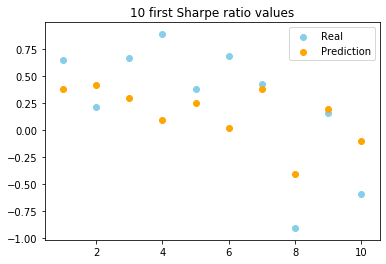

In [946]:
fig = plt.figure()
plt.scatter("x","y1", data=graph, color='skyblue', )
plt.scatter("x","y2", data=graph, color='orange')
plt.legend(["Real","Prediction"])
plt.title("10 first Sharpe ratio values")
plt.show();
fig.savefig("graph.png")

In [447]:
X["fpred"] = np.sign(X.pred)*np.exp(-1/abs(X.pred))

In [448]:
print(mean_absolute_error(y.smoothed, X.fpred))
X = X.drop(["pred","fpred"],axis=1)

0.5813801941071568


In [474]:
xgb_pred = xgb.predict(test[selection].values)

In [850]:
test["pred"] = xgb_pred

In [476]:
test.pred.to_csv("submissions/submission_xgb_mean5.csv")

In [479]:
test["fpred"] = np.sign(test.pred)*np.exp(-1/abs(test.pred))
test = test.drop(["pred","fpred"],axis=1)

### XGB 2

In [509]:
gkf = GroupKFold(5)
params = {
    #'learning_rate' : [0.01, 0.1, 0.2, 0.21],
    #'max_depth' : [2,3],
    'reg_alpha' : [45, 49, 50, 50.5],
    'reg_lambda': [0.1, 1, 2],
}

search_xgb = GridSearchCV(XGBRegressor(max_depth=2,
                                                 ),
                      params,
                      scoring='neg_mean_absolute_error', 
                      n_jobs= -1,
                      cv=gkf.split(X.loc[:, :], y.smoothed, id_group))
search_xgb.fit(X[selection], y.smoothed)

[12:07:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1a3bab0dd0>,
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=2,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'reg_alpha': [45, 49, 50, 50.5],
             

In [510]:
search_xgb.best_params_

{'reg_alpha': 49, 'reg_lambda': 1}

In [511]:
xgb_model = []
train_res = []
test_res = []

gkf = GroupKFold(5)
for i, (train_index, test_index) in enumerate(gkf.split(X.loc[:, :], y.smoothed, id_group)):
        train_X_fold = X.iloc[train_index, :].loc[:, selection].values
        train_Y_fold = y.smoothed.iloc[train_index].values
        test_X_fold = X.iloc[test_index, :].loc[:, selection].values
        test_Y_fold = y.smoothed.iloc[test_index].values
        
        xgb = XGBRegressor(max_depth=2, n_jobs=-1, 
                           learning_rate = 0.2, 
                           reg_alpha = 49, 
                           reg_lambda = 1)
        
        xgb.fit(train_X_fold, train_Y_fold)
        
        train_preds = xgb.predict(train_X_fold)
        test_preds = xgb.predict(test_X_fold)
        mae_train = mean_absolute_error(train_Y_fold, train_preds)
        mae_test = mean_absolute_error(test_Y_fold, test_preds)
        train_res.append(mae_train)
        test_res.append(mae_test)
        
        xgb_model.append(xgb)
        
np.mean(train_res), np.mean(test_res)

[12:07:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:07:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:07:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:07:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:07:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.40469801477718087, 0.5565668385756537)

### RNN 

#### LSTM Univariate model / xgboost

In [ ]:
X_train_I1 = X_train.loc[:,"I_1_lag_20":"I_1_lag_0"]
X_train_I2 = X_train.loc[:,"I_2_lag_20":"I_2_lag_0"]
X_train_I3 = X_train.loc[:,"I_3_lag_20":"I_3_lag_0"]
X_train_I4 = X_train.loc[:,"I_4_lag_20":"I_4_lag_0"]
X_train_I5 = X_train.loc[:,"I_5_lag_20":"I_5_lag_0"]
X_train_I6 = X_train.loc[:,"I_6_lag_20":"I_6_lag_0"]
X_train_I7 = X_train.loc[:,"I_7_lag_20":"I_7_lag_0"]

In [ ]:
X_val_I1 = X_val.loc[:,"I_1_lag_20":"I_1_lag_0"]
X_val_I2 = X_val.loc[:,"I_2_lag_20":"I_2_lag_0"]
X_val_I3 = X_val.loc[:,"I_3_lag_20":"I_3_lag_0"]
X_val_I4 = X_val.loc[:,"I_4_lag_20":"I_4_lag_0"]
X_val_I5 = X_val.loc[:,"I_5_lag_20":"I_5_lag_0"]
X_val_I6 = X_val.loc[:,"I_6_lag_20":"I_6_lag_0"]
X_val_I7 = X_val.loc[:,"I_7_lag_20":"I_7_lag_0"]

In [ ]:
X_test_I1 = test.loc[:,"I_1_lag_20":"I_1_lag_0"]
X_test_I2 = test.loc[:,"I_2_lag_20":"I_2_lag_0"]
X_test_I3 = test.loc[:,"I_3_lag_20":"I_3_lag_0"]
X_test_I4 = test.loc[:,"I_4_lag_20":"I_4_lag_0"]
X_test_I5 = test.loc[:,"I_5_lag_20":"I_5_lag_0"]
X_test_I6 = test.loc[:,"I_6_lag_20":"I_6_lag_0"]
X_test_I7 = test.loc[:,"I_7_lag_20":"I_7_lag_0"]

In [ ]:
X_train_I1 = sc_x.fit_transform(X_train_I1)
X_train_I2 = sc_x.fit_transform(X_train_I2)
X_train_I3 = sc_x.fit_transform(X_train_I3)
X_train_I4 = sc_x.fit_transform(X_train_I4)
X_train_I5 = sc_x.fit_transform(X_train_I5)
X_train_I6 = sc_x.fit_transform(X_train_I6)
X_train_I7 = sc_x.fit_transform(X_train_I7)

In [ ]:
X_val_I1 = sc_x.transform(X_val_I1)
X_val_I2 = sc_x.transform(X_val_I2)
X_val_I3 = sc_x.transform(X_val_I3)
X_val_I4 = sc_x.transform(X_val_I4)
X_val_I5 = sc_x.transform(X_val_I5)
X_val_I6 = sc_x.transform(X_val_I6)
X_val_I7 = sc_x.transform(X_val_I7)

In [ ]:
X_test_I1 = sc_x.transform(X_test_I1)
X_test_I2 = sc_x.transform(X_test_I2)
X_test_I3 = sc_x.transform(X_test_I3)
X_test_I4 = sc_x.transform(X_test_I4)
X_test_I5 = sc_x.transform(X_test_I5)
X_test_I6 = sc_x.transform(X_test_I6)
X_test_I7 = sc_x.transform(X_test_I7)

In [ ]:
X_train_I1 = np.expand_dims(X_train_I1, axis=-1)
X_train_I2 = np.expand_dims(X_train_I2, axis=-1)
X_train_I3 = np.expand_dims(X_train_I3, axis=-1)
X_train_I4 = np.expand_dims(X_train_I4, axis=-1)
X_train_I5 = np.expand_dims(X_train_I5, axis=-1)
X_train_I6 = np.expand_dims(X_train_I6, axis=-1)
X_train_I7 = np.expand_dims(X_train_I7, axis=-1)

In [ ]:
X_val_I1 = np.expand_dims(X_val_I1, axis=-1)
X_val_I2 = np.expand_dims(X_val_I2, axis=-1)
X_val_I3 = np.expand_dims(X_val_I3, axis=-1)
X_val_I4 = np.expand_dims(X_val_I4, axis=-1)
X_val_I5 = np.expand_dims(X_val_I5, axis=-1)
X_val_I6 = np.expand_dims(X_val_I6, axis=-1)
X_val_I7 = np.expand_dims(X_val_I7, axis=-1)

In [ ]:
X_test_I1 = np.expand_dims(X_test_I1, axis=-1)
X_test_I2 = np.expand_dims(X_test_I2, axis=-1)
X_test_I3 = np.expand_dims(X_test_I3, axis=-1)
X_test_I4 = np.expand_dims(X_test_I4, axis=-1)
X_test_I5 = np.expand_dims(X_test_I5, axis=-1)
X_test_I6 = np.expand_dims(X_test_I6, axis=-1)
X_test_I7 = np.expand_dims(X_test_I7, axis=-1)

In [ ]:
BATCH_SIZE = 158
BUFFER_SIZE = 10000

In [ ]:
train_univariate_1 = tf.data.Dataset.from_tensor_slices((X_train_I1, y_train.smoothed)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_univariate_2 = tf.data.Dataset.from_tensor_slices((X_train_I2, y_train.smoothed)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_univariate_3 = tf.data.Dataset.from_tensor_slices((X_train_I3, y_train.smoothed)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_univariate_4 = tf.data.Dataset.from_tensor_slices((X_train_I4, y_train.smoothed)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_univariate_5 = tf.data.Dataset.from_tensor_slices((X_train_I5, y_train.smoothed)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_univariate_6 = tf.data.Dataset.from_tensor_slices((X_train_I6, y_train.smoothed)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_univariate_7 = tf.data.Dataset.from_tensor_slices((X_train_I7, y_train.smoothed)).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()


In [ ]:
val_univariate_1 = tf.data.Dataset.from_tensor_slices((X_val_I1, y_val.smoothed)).batch(BATCH_SIZE).repeat()
val_univariate_2 = tf.data.Dataset.from_tensor_slices((X_val_I2, y_val.smoothed)).batch(BATCH_SIZE).repeat()
val_univariate_3 = tf.data.Dataset.from_tensor_slices((X_val_I3, y_val.smoothed)).batch(BATCH_SIZE).repeat()
val_univariate_4 = tf.data.Dataset.from_tensor_slices((X_val_I4, y_val.smoothed)).batch(BATCH_SIZE).repeat()
val_univariate_5 = tf.data.Dataset.from_tensor_slices((X_val_I5, y_val.smoothed)).batch(BATCH_SIZE).repeat()
val_univariate_6 = tf.data.Dataset.from_tensor_slices((X_val_I6, y_val.smoothed)).batch(BATCH_SIZE).repeat()
val_univariate_7 = tf.data.Dataset.from_tensor_slices((X_val_I7, y_val.smoothed)).batch(BATCH_SIZE).repeat()

In [ ]:
print(val_univariate_1.take(1))
y_train.smoothed.shape

In [ ]:
def R2(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [ ]:
simple_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X_train_I1.shape[-2:]),
    tf.keras.layers.Dense(1)])
simple_lstm_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X_train_I1.shape[-2:]),
    tf.keras.layers.Dense(1)])
simple_lstm_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X_train_I1.shape[-2:]),
    tf.keras.layers.Dense(1)])
simple_lstm_model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X_train_I1.shape[-2:]),
    tf.keras.layers.Dense(1)])
simple_lstm_model_5 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X_train_I1.shape[-2:]),
    tf.keras.layers.Dense(1)])
simple_lstm_model_6 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X_train_I1.shape[-2:]),
    tf.keras.layers.Dense(1)])
simple_lstm_model_7 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=X_train_I1.shape[-2:]),
    tf.keras.layers.Dense(1)])

In [ ]:
simple_lstm_model_1.compile(optimizer='adam', loss='mae', metrics=[R2])
simple_lstm_model_2.compile(optimizer='adam', loss='mae', metrics=[R2])
simple_lstm_model_3.compile(optimizer='adam', loss='mae', metrics=[R2])
simple_lstm_model_4.compile(optimizer='adam', loss='mae', metrics=[R2])
simple_lstm_model_5.compile(optimizer='adam', loss='mae', metrics=[R2])
simple_lstm_model_6.compile(optimizer='adam', loss='mae', metrics=[R2])
simple_lstm_model_7.compile(optimizer='adam', loss='mae', metrics=[R2])

In [ ]:
for x, _ in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

In [ ]:
EVALUATION_INTERVAL = 10
EPOCHS = 10

In [ ]:
history_1 = simple_lstm_model_1.fit(train_univariate_1, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_1, validation_steps=50)
print("-----------------------------------------------------------------------")
history_2 = simple_lstm_model_2.fit(train_univariate_2, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_2, validation_steps=50)
print("-----------------------------------------------------------------------")
history_3 = simple_lstm_model_3.fit(train_univariate_3, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_3, validation_steps=50)
print("-----------------------------------------------------------------------")
history_4 = simple_lstm_model_4.fit(train_univariate_4, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_4, validation_steps=50)
print("-----------------------------------------------------------------------")
history_5 = simple_lstm_model_5.fit(train_univariate_5, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_5, validation_steps=50)
print("-----------------------------------------------------------------------")
history_6 = simple_lstm_model_6.fit(train_univariate_6, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_6, validation_steps=50)
print("-----------------------------------------------------------------------")
history_7 = simple_lstm_model_7.fit(train_univariate_7, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_7, validation_steps=50)

In [ ]:
plt.plot(history_2.history["loss"], color="b", label="Training Loss")
plt.plot(history_2.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history["R2"], color="b", label = "Training R2")
plt.plot(history.history["val_R2"], color="r", label ="Validation R2")
plt.ylabel("R2")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
# prediction on train values
lstm_pred_I1 = simple_lstm_model_1.predict(X_train_I1)
lstm_pred_I2 = simple_lstm_model_2.predict(X_train_I2)
lstm_pred_I3 = simple_lstm_model_3.predict(X_train_I3)
lstm_pred_I4 = simple_lstm_model_4.predict(X_train_I4)
lstm_pred_I5 = simple_lstm_model_5.predict(X_train_I5)
lstm_pred_I6 = simple_lstm_model_6.predict(X_train_I6)
lstm_pred_I7 = simple_lstm_model_7.predict(X_train_I7)

In [ ]:
# prediction on validation values
lstm_val_pred_I1 = simple_lstm_model_1.predict(X_val_I1)
lstm_val_pred_I2 = simple_lstm_model_2.predict(X_val_I2)
lstm_val_pred_I3 = simple_lstm_model_3.predict(X_val_I3)
lstm_val_pred_I4 = simple_lstm_model_4.predict(X_val_I4)
lstm_val_pred_I5 = simple_lstm_model_5.predict(X_val_I5)
lstm_val_pred_I6 = simple_lstm_model_6.predict(X_val_I6)
lstm_val_pred_I7 = simple_lstm_model_7.predict(X_val_I7)

In [ ]:
# prediction on test values
lstm_test_pred_I1 = simple_lstm_model_1.predict(X_test_I1)
lstm_test_pred_I2 = simple_lstm_model_2.predict(X_test_I2)
lstm_test_pred_I3 = simple_lstm_model_3.predict(X_test_I3)
lstm_test_pred_I4 = simple_lstm_model_4.predict(X_test_I4)
lstm_test_pred_I5 = simple_lstm_model_5.predict(X_test_I5)
lstm_test_pred_I6 = simple_lstm_model_6.predict(X_test_I6)
lstm_test_pred_I7 = simple_lstm_model_7.predict(X_test_I7)

In [ ]:
d_train = {"lstm_pred_I1":lstm_pred_I1[:,0], "lstm_pred_I2":lstm_pred_I2[:,0], "lstm_pred_I3":lstm_pred_I3[:,0],
    "lstm_pred_I4":lstm_pred_I4[:,0], "lstm_pred_I5":lstm_pred_I5[:,0], "lstm_pred_I6":lstm_pred_I6[:,0], 
     "lstm_pred_I7":lstm_pred_I7[:,0]}
lstm_I_train = pd.DataFrame(data=d_train, index=X_train.index)

In [ ]:
lstm_wI_train = pd.concat([X_train.iloc[:,0:7], lstm_I_train], axis=1)

In [ ]:
d_val = {"lstm_pred_I1":lstm_val_pred_I1[:,0], "lstm_pred_I2":lstm_val_pred_I2[:,0], "lstm_pred_I3":lstm_val_pred_I3[:,0],
    "lstm_pred_I4":lstm_val_pred_I4[:,0], "lstm_pred_I5":lstm_val_pred_I5[:,0], "lstm_pred_I6":lstm_val_pred_I6[:,0], 
     "lstm_pred_I7":lstm_val_pred_I7[:,0]}
lstm_I_val = pd.DataFrame(data=d_val, index=X_val.index)

In [ ]:
lstm_wI_val = pd.concat([X_val.iloc[:,0:7], lstm_I_val], axis=1)

In [ ]:
lstm_wI_val

In [ ]:
d_test = {"lstm_pred_I1":lstm_test_pred_I1[:,0], "lstm_pred_I2":lstm_test_pred_I2[:,0], "lstm_pred_I3":lstm_test_pred_I3[:,0],
    "lstm_pred_I4":lstm_test_pred_I4[:,0], "lstm_pred_I5":lstm_test_pred_I5[:,0], "lstm_pred_I6":lstm_test_pred_I6[:,0], 
     "lstm_pred_I7":lstm_test_pred_I7[:,0]}
lstm_I_test = pd.DataFrame(data=d_test, index=test.index)

In [ ]:
lstm_wI_test = pd.concat([test.iloc[:,0:7], lstm_I_test], axis=1)

In [ ]:
# Let's train an adaboost on the lstm predictions

In [ ]:
adaboost = AdaBoostRegressor()
adaboost.fit(lstm_wI_train, y_train.smoothed)

In [ ]:
ada_train_pred = adaboost.predict(lstm_wI_train)
ada_val_pred = adaboost.predict(lstm_wI_val)
ada_test_pred = adaboost.predict(lstm_wI_test)

In [ ]:
lstm_wI_train["pred"] = ada_train_pred
lstm_wI_val["pred"] = ada_val_pred
lstm_wI_test["pred"] = ada_test_pred

In [ ]:
lstm_wI_train["fpred"] = np.sign(lstm_wI_train["pred"])*np.exp(-1/abs(lstm_wI_train["pred"]))
lstm_wI_val["fpred"] = np.sign(lstm_wI_val["pred"])*np.exp(-1/abs(lstm_wI_val["pred"]))
lstm_wI_test["fpred"] = np.sign(lstm_wI_test["pred"])*np.exp(-1/abs(lstm_wI_test["pred"]))

In [ ]:
print(mean_absolute_error(y_train.smoothed,lstm_wI_train["fpred"]))
print(mean_absolute_error(y_val.smoothed,lstm_wI_val["fpred"]))

Submission of the lstm/adaboost model on raw data

In [ ]:
lstm_wI_test.fpred.to_csv("submission_lstm_adaboost")